<a href="https://colab.research.google.com/github/Piras2024/quantized-dql-mountaincar/blob/main/First_Itaration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
# Define model
class DQN(nn.Module):
    def __init__(self, num_actions, input_dim):
        super().__init__()

        self.FC = nn.Sequential(
            nn.Linear(input_dim, 12),
            nn.ReLU(inplace=True),
            nn.Linear(12, 8),
            nn.ReLU(inplace=True),
            nn.Linear(8, num_actions)
            )

        # Initialize FC layer weights using He initialization
        for layer in [self.FC]:
            for module in layer:
                if isinstance(module, nn.Linear):
                    nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')

    def forward(self, x):
        Q = self.FC(x)
        return Q

# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
# MountainCar Deep Q-Learning
class MountainCarDQL():

    loss_fn = nn.MSELoss()          # NN Loss function. MSE=Mean Squared Error can be swapped to something else.
    optimizer = None                # NN Optimizer. Initialize later.

    def __init__(self, learning_rate_a=75e-5, discount_factor_g=0.96, network_sync_rate=100, replay_memory_size=100000, mini_batch_size=64, num_discrete_actions=10, seed=None):
        self.learning_rate_a = learning_rate_a
        self.discount_factor_g = discount_factor_g
        self.network_sync_rate = network_sync_rate
        self.replay_memory_size = replay_memory_size
        self.mini_batch_size = mini_batch_size
        self.num_discrete_actions = num_discrete_actions
        self.seed = seed

        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)
            torch.manual_seed(self.seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed(self.seed)
                torch.backends.cudnn.deterministic = True
                torch.backends.cudnn.benchmark = False


    # Train the environment
    def train(self, episodes, render=False):
        # Create MountainCarContinuous instance
        env = gym.make('MountainCarContinuous-v0', render_mode='rgb_array')
        # Wrap the environment with RecordVideo
        env = gym.wrappers.RecordVideo(env, video_folder='mountaincar_train_video', episode_trigger=lambda x: x % 1000 == 0) # Record every 1000 episodes during training

        # Set the seed for the environment
        if self.seed is not None:
            env.reset(seed=self.seed)


        # Get continuous action space bounds
        min_action = env.action_space.low[0]
        max_action = env.action_space.high[0]

        # Create discrete actions using linspace
        self.discrete_actions = np.linspace(min_action, max_action, self.num_discrete_actions)

        num_states = env.observation_space.shape[0] # expecting 2: position & velocity
        num_actions = self.num_discrete_actions # Use the number of discrete actions

        epsilon = 1 # 1 = 100% random actions
        memory = ReplayMemory(self.replay_memory_size)

        # Create policy and target network. Number of nodes in the hidden layer can be adjusted.
        policy_dqn = DQN(input_dim=num_states, num_actions=num_actions)
        target_dqn = DQN(input_dim=num_states, num_actions=num_actions)

        # Make the target and policy networks the same (copy weights/biases from one network to the other)
        target_dqn.load_state_dict(policy_dqn.state_dict())

        # Policy network optimizer. "Adam" optimizer can be swapped to something else.
        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

        # List to keep track of rewards collected per episode. Initialize list to 0's.
        rewards_per_episode = []

        # List to keep track of epsilon decay
        epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        step_count=0
        best_rewards=-1000 # Adjusted initial best_rewards for continuous env
        goal_reached=False

        for i in range(episodes):

            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False

            rewards = 0

            # Agent navigates map until it falls into hole/reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated): # The reward threshold might need adjustment for continuous env

                # Select action based on epsilon-greedy
                if random.random() < epsilon:
                    # select random action (index for discrete actions) uniformly
                    action_index = random.randrange(self.num_discrete_actions)

                else:
                    # select best action (index for discrete actions)
                    with torch.no_grad():
                        # Use the continuous state as input and get the index of the best discrete action
                        action_index = policy_dqn(self.state_to_dqn_input(state)).argmax().item()

                # Map the discrete action index to the continuous action value
                action = self.discrete_actions[action_index]

                # Execute action - MountainCarContinuous expects a single value action in a list
                new_state,reward,terminated,truncated,_ = env.step([action])

                # Add a small negative reward at each timestep to discourage staying in the valley
                reward -= 1

                # Accumulate reward
                rewards += reward

                # Save experience into memory
                memory.append((state, action_index, new_state, reward, terminated)) # Store action_index, not continuous action value

                # Move to the next state
                state = new_state

                # Increment step counter
                step_count+=1

            # Keep track of the rewards collected per episode.
            rewards_per_episode.append(rewards)

            # Log reward per episode to wandb
            wandb.log({"reward_per_episode": rewards}, step=i)


            # Check if goal was reached
            if(terminated):
                goal_reached = True

            # Graph training progress
            if(i!=0 and i%1000==0):
                print(f'Episode {i} Epsilon {epsilon}')

                #self.plot_progress(rewards_per_episode, epsilon_history)
                #torch.save(policy_dqn.state_dict(), f"mountaincar_autosave_dql_{i}.pt")


            if rewards>best_rewards:
                best_rewards = rewards
                print(f'Best rewards so far: {best_rewards}')
                # Save policy
                torch.save(policy_dqn.state_dict(), f"mountaincar_dql_{i}.pt")


            # Check if enough experience has been collected AND goal was reached in this episode
            if len(memory)>self.mini_batch_size and goal_reached: # Restored 'and goal_reached'
                mini_batch = memory.sample(self.mini_batch_size) # Use mini_batch_size for sampling
                self.optimize(mini_batch, policy_dqn, target_dqn)

                # Decay epsilon
                epsilon = max(epsilon - 1/episodes, 0)
                epsilon_history.append(epsilon)

                # Log epsilon to wandb
                wandb.log({"epsilon": epsilon}, step=i)

                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count=0

        # Close environment
        env.close()
    def plot_progress(self, rewards_per_episode, epsilon_history):
        # Create new graph
        plt.figure(1)

        # Plot average rewards (Y-axis) vs episodes (X-axis)
        # rewards_curve = np.zeros(len(rewards_per_episode))
        # for x in range(len(rewards_per_episode)):
            # rewards_curve[x] = np.min(rewards_per_episode[max(0, x-10):(x+1)])
        plt.subplot(121) # plot on a 1 row x 2 col grid, at cell 1
        # plt.plot(sum_rewards)
        plt.plot(rewards_per_episode)

        # Plot epsilon decay (Y-axis) vs episodes (X-axis)
        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        plt.plot(epsilon_history)

        # Save plots
        plt.savefig('mountaincar_dql.png')
    # Optimize policy network
    def optimize(self, mini_batch, policy_dqn, target_dqn):

        current_q_list = []
        target_q_list = []

        for state, action_index, new_state, reward, terminated in mini_batch: # Use action_index

            if terminated:
                # Agent receive reward of 0 for reaching goal.
                # When in a terminated state, target q value should be set to the reward.
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value
                with torch.no_grad():
                    # Use the continuous state as input
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state)).max()
                    )

            # Get the current set of Q values
            # Use the continuous state as input
            current_q = policy_dqn(self.state_to_dqn_input(state))
            current_q_list.append(current_q)

            # Get the target set of Q values
            # Use the continuous state as input
            target_q = target_dqn(self.state_to_dqn_input(state))
            # Adjust the specific action (index) to the target that was just calculated
            target_q[action_index] = target
            target_q_list.append(target_q)

        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    '''
    Converts a state (position, velocity) to tensor representation for continuous observation space.
    Example:
    Input = (0.3, -0.03)
    Return = tensor([0.3, -0.03])
    '''
    def state_to_dqn_input(self, state)->torch.Tensor:
        # The state is already a NumPy array [position, velocity]
        # Convert it directly to a PyTorch FloatTensor
        return torch.FloatTensor(state)

    # Run the environment with the learned policy
    def test(self, episodes, model_filepath):
        # Create FrozenLake instance
        # Wrap the environment with RecordVideo
        env = gym.make('MountainCarContinuous-v0', render_mode='rgb_array')
        env = gym.wrappers.RecordVideo(env, video_folder='mountaincar_test_video', episode_trigger=lambda x: True) # Record every episode

        # Set the seed for the environment
        #if self.seed is not None:
        #    env.reset(seed=self.seed)

        # Get continuous action space bounds
        min_action = env.action_space.low[0]
        max_action = env.action_space.high[0]

        # Create discrete actions using linspace
        self.discrete_actions = np.linspace(min_action, max_action, self.num_discrete_actions)


        num_states = env.observation_space.shape[0]
        num_actions = self.num_discrete_actions # Use the number of discrete actions


        # Divide position and velocity into segments - No longer needed for continuous observation space
        # self.pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)    # Between -1.2 and 0.6
        # self.vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)    # Between -0.07 and 0.07


        # Load learned policy
        policy_dqn = DQN(input_dim=num_states, num_actions=num_actions)
        policy_dqn.load_state_dict(torch.load(model_filepath))
        policy_dqn.eval()    # switch model to evaluation mode

        total_test_rewards = 0
        test_rewards_list = []
        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions
            rewards = 0

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):
                # Select best action (index)
                with torch.no_grad():
                    # Use the continuous state as input and get the index of the best discrete action
                    action_index = policy_dqn(self.state_to_dqn_input(state)).argmax().item()

                # Map the discrete action index to the continuous action value
                action = self.discrete_actions[action_index]

                # Execute action - MountainCarContinuous expects a single value action in a list
                state,reward,terminated,truncated,_ = env.step([action])
                rewards += reward

            total_test_rewards += rewards
            test_rewards_list.append(rewards)

            # Check if the goal was reached (terminated without truncation)
            # MountainCarContinuous-v0 terminates when the flag is reached (position >= 0.5)
            if terminated:
                print(f"Episode {i+1}: Goal Reached! Reward: {rewards}")
            elif truncated:
                print(f"Episode {i+1}: Episode truncated (did not reach goal). Reward: {rewards}")
            else: # This case should not happen in MountainCarContinuous if not truncated
                 print(f"Episode {i+1}: Episode terminated unexpectedly. Reward: {rewards}")

        # Calculate and Log average test reward to wandb
        if episodes > 0:
            avg_test_reward = total_test_rewards / episodes
            wandb.log({"average_test_reward": avg_test_reward})
            print(f"Average test reward over {episodes} episodes: {avg_test_reward}")
        else:
            print("No test episodes run.")

        # Log test videos to wandb
        # Assuming videos are saved in 'mountaincar_test_video' directory
        # Wandb can log video files directly.
        # We need to find the video files generated during this test run.
        # The RecordVideo wrapper names videos based on the episode index.
        video_files = glob.glob('mountaincar_test_video/rl-video-episode-*.mp4')
        if video_files:
            print(f"Logging {len(video_files)} test videos to wandb.")
            for video_file in video_files:
                wandb.log({"test_video": wandb.Video(video_file)})
        else:
            print("No test videos found to log.")


        env.close()

In [ ]:
import glob
import os

# Pattern per i file da cancellare
file_pattern = "mountaincar_*.pt"

# Trova tutti i file che corrispondono al pattern
files_to_delete = glob.glob(file_pattern)

# Itera sui file trovati e cancellali
for file_path in files_to_delete:
    try:
        os.remove(file_path)
        print(f"Deleted: {file_path}")
    except OSError as e:
        print(f"Error deleting {file_path}: {e}")

print("Finished deleting files.")






Finished deleting files.


# Quantizzazione spazio delle azioni in 3 azioni

Best rewards so far: -874.0000000000093
Best rewards so far: -661.9000000000067
Best rewards so far: -549.8000000000051
Best rewards so far: -465.40000000000384
Best rewards so far: -379.80000000000257
Episode 1000 Epsilon 0.9500500000000055
Episode 2000 Epsilon 0.900050000000011
Best rewards so far: -294.2000000000013
Episode 3000 Epsilon 0.8500500000000165
Episode 4000 Epsilon 0.800050000000022
Episode 5000 Epsilon 0.7500500000000275
Episode 6000 Epsilon 0.700050000000033
Best rewards so far: -230.20000000000036
Episode 7000 Epsilon 0.6500500000000385
Episode 8000 Epsilon 0.600050000000044
Episode 9000 Epsilon 0.5500500000000496
Episode 10000 Epsilon 0.5000500000000551
Episode 11000 Epsilon 0.45005000000006057
Best rewards so far: -183.1999999999997
Best rewards so far: -104.19999999999956
Episode 12000 Epsilon 0.4000500000000661
Best rewards so far: -99.69999999999962
Best rewards so far: -89.69999999999965
Episode 13000 Epsilon 0.3500500000000716
Episode 14000 Epsilon 0.30005000000

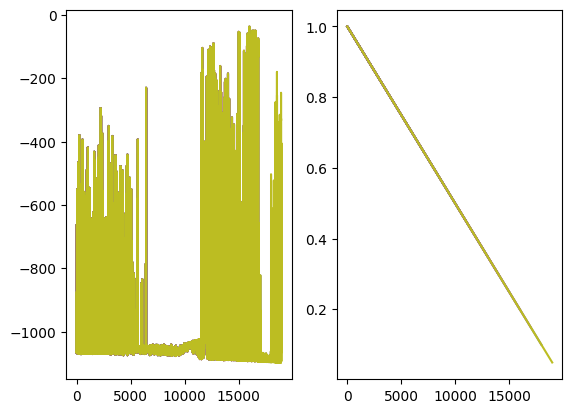

In [ ]:
mountaincar = MountainCarDQL(num_discrete_actions=3, learning_rate_a=0.001, discount_factor_g=0.99, seed=2025)

mountaincar.train(20000, False)

**Reasoning**:
The training has completed. Now, execute the test cell to evaluate the performance of the trained agent. Make sure to update the model filepath to the latest saved model if necessary.



In [ ]:
# Find the latest saved model file
import glob
import os

list_of_files = glob.glob('mountaincar_dql_*.pt')
if list_of_files:
    latest_file = max(list_of_files, key=os.path.getctime)
    print(f"Using latest model file: {latest_file}")
else:
    latest_file = None
    print("No model files found. Cannot run test.")

if latest_file:
    mountaincar.test(20, latest_file)
else:
    print("Test skipped due to missing model file.")

Using latest model file: mountaincar_dql_16009.pt
Episode 1: Goal Reached! Reward: 86.70000000000003
Episode 2: Goal Reached! Reward: 90.20000000000002
Episode 3: Goal Reached! Reward: 90.20000000000002
Episode 4: Goal Reached! Reward: 90.40000000000002
Episode 5: Goal Reached! Reward: 88.30000000000003
Episode 6: Goal Reached! Reward: 86.80000000000003
Episode 7: Goal Reached! Reward: 90.20000000000002
Episode 8: Goal Reached! Reward: 90.10000000000002
Episode 9: Goal Reached! Reward: 86.80000000000003
Episode 10: Goal Reached! Reward: 86.60000000000004
Episode 11: Goal Reached! Reward: 86.80000000000003
Episode 12: Goal Reached! Reward: 88.00000000000003
Episode 13: Goal Reached! Reward: 88.00000000000003
Episode 14: Goal Reached! Reward: 90.40000000000002
Episode 15: Goal Reached! Reward: 86.40000000000003
Episode 16: Goal Reached! Reward: 88.40000000000002
Episode 17: Goal Reached! Reward: 86.30000000000004
Episode 18: Goal Reached! Reward: 86.80000000000003
Episode 19: Goal Reache

In fase di test si osserva un reward massimo di 90.2


# Quantizzazione dello spazio delle azioni in 10 azioni

In [ ]:
import wandb

# Define hyperparameters
hyperparameters = {
    "learning_rate_a": 0.001,
    "discount_factor_g": 0.99,
    "network_sync_rate": 100,
    "replay_memory_size": 100000,
    "mini_batch_size": 64,
    "num_discrete_actions": 10,
    "seed": 2025
}

wandb.init(project="MountainCar DQL", name="MountainCar_DQL_Run_10_Actions", config=hyperparameters)

In [ ]:
import glob
import os

# Pattern per i file da cancellare
file_pattern = "mountaincar_*.pt"

# Trova tutti i file che corrispondono al pattern
files_to_delete = glob.glob(file_pattern)

# Itera sui file trovati e cancellali
for file_path in files_to_delete:
    try:
        os.remove(file_path)
        print(f"Deleted: {file_path}")
    except OSError as e:
        print(f"Error deleting {file_path}: {e}")

print("Finished deleting files.")

Deleted: mountaincar_dql_2222.pt
Deleted: mountaincar_autosave_dql_7000.pt
Deleted: mountaincar_autosave_dql_3000.pt
Deleted: mountaincar_autosave_dql_4000.pt
Deleted: mountaincar_autosave_dql_8000.pt
Deleted: mountaincar_autosave_dql_6000.pt
Deleted: mountaincar_dql_15010.pt
Deleted: mountaincar_autosave_dql_19000.pt
Deleted: mountaincar_dql_11636.pt
Deleted: mountaincar_dql_12679.pt
Deleted: mountaincar_dql_12363.pt
Deleted: mountaincar_autosave_dql_9000.pt
Deleted: mountaincar_autosave_dql_5000.pt
Deleted: mountaincar_dql_238.pt
Deleted: mountaincar_autosave_dql_18000.pt
Deleted: mountaincar_autosave_dql_14000.pt
Deleted: mountaincar_dql_6427.pt
Deleted: mountaincar_autosave_dql_1000.pt
Deleted: mountaincar_dql_15013.pt
Deleted: mountaincar_dql_143.pt
Deleted: mountaincar_dql_11534.pt
Deleted: mountaincar_autosave_dql_13000.pt
Deleted: mountaincar_autosave_dql_11000.pt
Deleted: mountaincar_autosave_dql_16000.pt
Deleted: mountaincar_autosave_dql_15000.pt
Deleted: mountaincar_dql_65.p

In [ ]:
mountaincar = MountainCarDQL(num_discrete_actions=10, learning_rate_a=0.001, discount_factor_g=0.99, seed=2025)

mountaincar.train(20000, False)

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /content/mountaincar_train_video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Best rewards so far: -929.0691370393114
Best rewards so far: -779.5481491676148
Best rewards so far: -627.4345687779411
Episode 1000 Epsilon 0.9505000000000055
Best rewards so far: -585.0444452457979
Best rewards so far: -408.5888894809612
Best rewards so far: -307.18642029247087
Episode 2000 Epsilon 0.900500000000011
Episode 3000 Epsilon 0.8505000000000165
Episode 4000 Epsilon 0.800500000000022
Episode 5000 Epsilon 0.7505000000000275
Episode 6000 Epsilon 0.700500000000033
Episode 7000 Epsilon 0.6505000000000385
Episode 8000 Epsilon 0.600500000000044
Episode 9000 Epsilon 0.5505000000000495
Episode 10000 Epsilon 0.500500000000055
Episode 11000 Epsilon 0.4505000000000605
Episode 12000 Epsilon 0.400500000000066
Best rewards so far: -208.33950662642272
Best rewards so far: -110.01604971326367
Best rewards so far: -102.8000003019963
Episode 13000 Epsilon 0.35050000000007153
Episode 14000 Epsilon 0.30050000000007704
Episode 15000 Epsilon 0.25050000000008255
Episode 16000 Epsilon 0.2005000000

In [ ]:
# Find the latest saved model file
import glob
import os

list_of_files = glob.glob('mountaincar_dql_*.pt')
if list_of_files:
    latest_file = max(list_of_files, key=os.path.getctime)
    print(f"Using latest model file: {latest_file}")
else:
    latest_file = None
    print("No model files found. Cannot run test.")

if latest_file:
    mountaincar.test(20, latest_file)
else:
    print("Test skipped due to missing model file.")

Using latest model file: mountaincar_dql_12870.pt


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /content/mountaincar_test_video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode 1: Goal Reached! Reward: 93.72592558772477
Episode 2: Goal Reached! Reward: 93.74938236048193
Episode 3: Goal Reached! Reward: 93.81111076540418
Episode 4: Goal Reached! Reward: 94.80493795444937
Episode 5: Goal Reached! Reward: 95.71728371146284
Episode 6: Goal Reached! Reward: 95.51357999363063
Episode 7: Goal Reached! Reward: 95.85925902834644
Episode 8: Goal Reached! Reward: 93.69876507461808
Episode 9: Goal Reached! Reward: 93.71975275425265
Episode 10: Goal Reached! Reward: 95.89876520177464
Episode 11: Goal Reached! Reward: 93.81111076540418
Episode 12: Goal Reached! Reward: 95.92098742929505
Episode 13: Goal Reached! Reward: 93.77037001627464
Episode 14: Goal Reached! Reward: 93.75802435992678
Episode 15: Goal Reached! Reward: 95.92098742929505
Episode 16: Goal Reached! Reward: 93.76049347424214
Episode 17: Goal Reached! Reward: 93.71851815735853
Episode 18: Goal Reached! Reward: 95.8296293956262
Episode 19: Goal Reached! Reward: 93.84197496587849


wandb: WARNING `format` argument was not provided, defaulting to `gif`. This parameter will be required in v0.20.0, please specify the format explicitly.


Episode 20: Goal Reached! Reward: 93.72716013163698
Average test reward over 20 episodes: 94.52790092785419
Logging 21 test videos to wandb.


wandb: WARNING `format` argument was not provided, defaulting to `gif`. This parameter will be required in v0.20.0, please specify the format explicitly.
wandb: WARNING `format` argument was not provided, defaulting to `gif`. This parameter will be required in v0.20.0, please specify the format explicitly.
wandb: WARNING `format` argument was not provided, defaulting to `gif`. This parameter will be required in v0.20.0, please specify the format explicitly.
wandb: WARNING `format` argument was not provided, defaulting to `gif`. This parameter will be required in v0.20.0, please specify the format explicitly.
wandb: WARNING `format` argument was not provided, defaulting to `gif`. This parameter will be required in v0.20.0, please specify the format explicitly.
wandb: WARNING `format` argument was not provided, defaulting to `gif`. This parameter will be required in v0.20.0, please specify the format explicitly.
wandb: WARNING `format` argument was not provided, defaulting to `gif`. This

Con 10 Azioni si osserva un avg reward di 94.5 su 20 tests